In [1]:
import sys
import time
import matplotlib.pyplot as plt
import wordninja

from pullnet import PullNet
from graftnet import GraftNet
from pullnet_data_loader import DataLoader
from fpnet_data_loader import FpNetDataLoader
from relreasoner_data_loader import RelReasonerDataLoader
from fpnet import FactsPullNet
from util import *
from multiprocessing.pool import Pool
from preprocessing import use_helper
from collections import defaultdict
from string import punctuation


import warnings
warnings.filterwarnings("ignore")

/home/hxssg1124/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hxssg1124/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hxssg1124/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hxssg1124/anaconda3/lib/python3.7/site-packages/tensorflow/python/f

In [10]:
cfg = get_config('config/relreasoner_metaqa3.yml')
facts = load_fact2(cfg['fact_data'])
facts_rel = load_fact(cfg['fact_data'])
word2id = load_dict(cfg['data_folder'] + cfg['word2id'])
relation2id = load_dict(cfg['data_folder'] + cfg['relation2id'])
entity2id = load_dict(cfg['data_folder'] + cfg['entity2id'])
num_hop = 3

In [4]:
train_data = load_json(cfg['data_folder'] + cfg['train_data'])
dev_data = load_json(cfg['data_folder'] + cfg['dev_data'])
test_data = load_json(cfg['data_folder'] + cfg['test_data'])

## Load question types

In [9]:
with open(cfg['data_folder'] + 'qa_train_qtype.txt') as f:
    train_qtypes = f.readlines()
with open(cfg['data_folder'] + 'qa_dev_qtype.txt') as f:
    dev_qtypes = f.readlines()
with open(cfg['data_folder'] + 'qa_test_qtype.txt') as f:
    test_qtypes = f.readlines()

In [55]:
REL_MAPPING = {
    'movie': {
        'actor': 'starred_actors',
        'writer': 'written_by',
        'director': 'directed_by',
        'language': 'in_language',
        'year': 'release_year',
        'genre': 'has_genre'
    }
}
tmp = defaultdict(dict)
for k1, v1 in REL_MAPPING.items():
    for k2, v2 in v1.items():
        tmp[k1][k2] = v2
        tmp[k2][k1] = v2
REL_MAPPING = tmp
for qtypes_data in [(train_qtypes, 'train'), (dev_qtypes, 'dev'), (test_qtypes, 'test')]:
    qtypes, data_type = qtypes_data
    for idx_e, e in enumerate(tqdm(qtypes)):
        e = e.strip()
        ts = e.split('_')
        rels = []
        for idx in range(0, len(ts) - 2, 2):
            rels.append(REL_MAPPING[ts[idx]][ts[idx+2]])
        if data_type == 'train':    
            train_data[idx_e]['rel_path'] = rels
        elif data_type == 'dev':
            dev_data[idx_e]['rel_path'] = rels
        else:
            test_data[idx_e]['rel_path'] = rels
save_json(train_data, cfg['data_folder'] + cfg['train_data'])
save_json(dev_data, cfg['data_folder'] + cfg['dev_data'])
save_json(test_data, cfg['data_folder'] + cfg['test_data'])

100%|██████████| 14274/14274 [00:00<00:00, 503545.08it/s]


In [60]:
train_data[5]['question']

'who wrote films that share actors with the film Anastasia ?'

In [61]:
train_data[5]['rel_path']

['starred_actors', 'starred_actors', 'written_by']

In [64]:
facts_rel['Anastasia']

{'directed_by': {'Anatole Litvak': 0, 'Don Bluth': 0, 'Gary Goldman': 0},
 'written_by': {'Guy Bolton': 0, 'Marcelle Maurette': 0},
 'starred_actors': {'Ingrid Bergman': 0,
  'Yul Brynner': 0,
  'Helen Hayes': 0,
  'John Cusack': 0,
  'Christopher Lloyd': 0,
  'Meg Ryan': 0,
  'Kelsey Grammer': 0},
 'release_year': {'1956': 0, '1997': 0},
 'has_genre': {'Drama': 0, 'Animation': 0},
 'has_tags': {'bd-r': 0,
  'ingrid bergman': 0,
  'yul brynner': 0,
  'anatole litvak': 0,
  'helen hayes': 0,
  'animation': 0,
  'music': 0,
  'kirsten dunst': 0,
  'meg ryan': 0,
  'christopher lloyd': 0,
  'russia': 0}}

In [87]:
def find_paths_helper(entity, answers, num_hop, tmp_path, rel_path, visited):
    if entity in visited:
        return set()
    if num_hop == 0:
        if entity in answers:
            return {tuple(tmp_path)}
        return set()
    visited.add(entity)
    res = set()
    entity = entity.replace('%', '')
    cur_rel = rel_path[len(rel_path) - num_hop]
    if cur_rel not in facts_rel[entity]:
        return set()
    for k2 in facts_rel[entity][cur_rel]:
        v = find_paths_helper(k2, answers, num_hop - 1, tmp_path + [k2], rel_path, visited)
        res.update(v)
    return res

def find_paths(questions):
    res = []
    for e in tqdm(questions):
        visited = set()
        answers = set(map(lambda x: x['text'], e['answers']))
        entity = e['entities'][0]['text']
        v = find_paths_helper(entity, answers, 3, [entity], e['rel_path'], visited)
        e['path'] = list(v)
        res.append(e)
    return res

In [89]:
train_data = find_paths(train_data)
dev_data = find_paths(dev_data)
test_data = find_paths(test_data)

100%|██████████| 14274/14274 [00:00<00:00, 23527.41it/s]


In [99]:
save_json(train_data, cfg['data_folder'] + cfg['train_data'])
save_json(dev_data, cfg['data_folder'] + cfg['dev_data'])
save_json(test_data, cfg['data_folder'] + cfg['test_data'])

In [101]:
lens = []
for e in train_data:
    lens.append(len(set(e['rel_path'])))

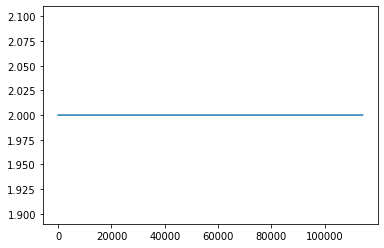

In [104]:
plt.plot(lens)
plt.show()

In [105]:
print(len(word2id))

9893


In [5]:
def clean_text(text, filter_dot=False):
    text = text.replace('.', ' . ').lower()
    for punc in punctuation:
        if punc != '.':
            text = text.replace(punc, " ")
    text = text.split()
    output = []
    for i in text:
        if len(i) < 10:
            output.append(i)
        else:
            output.extend(wordninja.split(i))
    if filter_dot:
        return [e for e in text if e != '.']
    return text

In [127]:
total_words = set()
for q in tqdm(dev_data):
    cleaned = clean_text(q['question'])
    total_words.update(cleaned)

100%|██████████| 14274/14274 [00:00<00:00, 57325.67it/s]


In [137]:
total_words = set()
for rel in relation2id:
    cleaned = clean_text(rel)
    total_words.update(cleaned)

In [138]:
print(len(total_words & set(word2id.keys())) / len(total_words))

1.0


In [133]:
total_words

{'actors',
 'by',
 'directed',
 'genre',
 'has',
 'imdb',
 'in',
 'language',
 'rating',
 'release',
 'starred',
 'tags',
 'votes',
 'written',
 'year'}

In [134]:
new_words = set(word2id.keys()) | total_words

In [135]:
with open('datasets/metaqa/3hop/vocab_new.txt', 'w') as f:
    for e in new_words:
        f.writelines(e + '\n')

In [143]:
idx = 0
train_data[idx]['question'], train_data[idx]['rel_path']

('the films that share actors with the film Dil Chahta Hai were released in which years ?',
 ['starred_actors', 'starred_actors', 'release_year'])

In [140]:
relation2id

{'has_imdb_rating': 0,
 'starred_actors': 1,
 'in_language': 2,
 'has_imdb_votes': 3,
 'has_tags': 4,
 'written_by': 5,
 'directed_by': 6,
 'has_genre': 7,
 'release_year': 8}

In [155]:
import torch

In [175]:
cvt = use_helper.UseVector()

In [176]:
rel_emb = {r: cvt.get_vector(r) for r in relation2id}

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Time for initialize graph:  1.2292625904083252
Time for init session:  1.1187412738800049


In [181]:
recall = 0.0
total = 0
for idx in tqdm(range(len(train_data)//10000)):
    q_emb = cvt.get_vector(train_data[idx]['question'])
    rel2score = dict()
    for rel, remb in rel_emb.items():
        qemb = torch.tensor(q_emb)
        remb = torch.tensor(remb)
        rel2score[rel] = torch.sigmoid(remb @ qemb.T).item()
    rels = set(map(lambda x: x[0], list(sorted(rel2score.items(), key=lambda x: x[1], reverse=True)[:2])))
    answers = set(train_data[idx]['rel_path'])
    recall += len(rels & answers) / len(answers)
    total += 1
    print('rel:', rels, ',answers:', answers)
print(recall / total)

100%|██████████| 11/11 [00:00<00:00, 91.87it/s]

rel: {'starred_actors', 'has_tags'} ,answers: {'starred_actors', 'release_year'}
rel: {'starred_actors', 'has_tags'} ,answers: {'written_by', 'directed_by'}
rel: {'starred_actors', 'has_tags'} ,answers: {'starred_actors', 'directed_by'}
rel: {'starred_actors', 'has_tags'} ,answers: {'starred_actors', 'directed_by'}
rel: {'starred_actors', 'has_tags'} ,answers: {'has_genre', 'directed_by'}
rel: {'starred_actors', 'has_tags'} ,answers: {'written_by', 'starred_actors'}
rel: {'starred_actors', 'has_tags'} ,answers: {'starred_actors', 'release_year'}
rel: {'starred_actors', 'has_tags'} ,answers: {'starred_actors', 'release_year'}
rel: {'has_tags', 'directed_by'} ,answers: {'in_language', 'directed_by'}
rel: {'starred_actors', 'has_tags'} ,answers: {'written_by', 'starred_actors'}
rel: {'starred_actors', 'has_tags'} ,answers: {'starred_actors', 'directed_by'}
0.4090909090909091


## Glove Embedding similarity 

In [8]:
import torch
import torch.nn as nn

In [9]:
num_word = len(word2id)
word_dim = 100
word_embedding = nn.Embedding(num_embeddings=num_word + 1, embedding_dim=word_dim, padding_idx=num_word)

In [11]:
word_embedding.weight = nn.Parameter(
                torch.from_numpy(np.pad(np.load('datasets/metaqa/3hop/word_emb_100d.npy'), ((0, 1), (0, 0)), 'constant')).type(
                    'torch.FloatTensor'))
word_embedding.weight.requires_grad = False

In [99]:
idx_q = 0
q = train_data[idx_q]
print(q['question'])
print(q['rel_path'])
for r in relation2id:
    print(r)
rels = list(relation2id.keys())
rel_emb = word_embedding
for rel in rels:
    rel_spt = clean_text(rel)
    rel_spt = list(filter(lambda x: x not in ('has', 'by', 'in', 'the'), rel_spt))
    q_spt = clean_text(q['question'])
    q_spt = list(filter(lambda x: x not in ('has', 'which', 'by', 'with', 'were', 'that', 'in', 'the'), q_spt))
    similarity = []
    rel_emb = []
    for rel_word in rel_spt:
        if rel_word in word2id:
            rel_word_emb = word_embedding(torch.tensor(word2id[rel_word], dtype=torch.int64))
        else:
            rel_word_emb = word_embedding(torch.tensor(word2id['__unk__'], dtype=torch.int64))
        rel_emb.append(rel_word_emb)
    rel_emb = sum(rel_emb) / len(rel_emb)
    for word in q_spt:
        word_emb = word_embedding(torch.tensor(word2id[word], dtype=torch.int64))
        similarity.append(torch.sigmoid(rel_emb @ word_emb.T / np.sqrt(word_dim)).item())
#         print('%s <--> %s, similarity: %.8f' % (word, rel_word, similarity[-1]))
    print('rel:', rel, ', similarity:', np.max(similarity))

the films that share actors with the film Dil Chahta Hai were released in which years ?
['starred_actors', 'starred_actors', 'release_year']
has_imdb_rating
starred_actors
in_language
has_imdb_votes
has_tags
written_by
directed_by
has_genre
release_year
rel: has_imdb_rating , similarity: 0.6172443628311157
rel: starred_actors , similarity: 0.9318690896034241
rel: in_language , similarity: 0.6172443628311157
rel: has_imdb_votes , similarity: 0.6172443628311157
rel: has_tags , similarity: 0.6172443628311157
rel: written_by , similarity: 0.9073621034622192
rel: directed_by , similarity: 0.9525083899497986
rel: has_genre , similarity: 0.6172443628311157
rel: release_year , similarity: 0.9408514499664307
